In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Efficient training of depth-one QAOA parameters

In this how-to we exemplify the efficient parameter scanner used with the efficient depth-one QAOA energy computation.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz

from qiskit_ibm_runtime import Sampler

from qiskit_aer import Aer

from qaoa_training_pipeline import DepthOneGammaScanTrainer, EfficientDepthOneEvaluator, DepthOneScanTrainer
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator

To exemplify these methods we use the Maximum Cut problem on the graph $G=(V, E)$ formulated as

\begin{align}
C_\text{max}=\max_{x\in\{0, 1\}^n}\sum_{i,j=0}^{n-1}w_{ij}\,x_i(1-x_j).
\end{align}
Here, $w_{i,j}$ are the weights of edge $(i,j)\in E$ and $C_\text{max}$ is the value of the maximum cut.
When converting to spin variables with $x_i=(1-z_i)/2$ this maximization corresponds to **maximizing** the cost operator

\begin{align}
H_C=-\sum_{(i,j)\in E}\frac{w_{ij}}{2}\,Z_iZ_j
\end{align}
Note that we have omitted the constant offsets here.
Now, we can convert the energy $\langle H_C\rangle$ to the value of the average cut through $C=\langle H_C\rangle +\sum_{(i,j)\in E}w_{ij}/2$.
We will exemplify this with the graph ${(0, 1), (0, 2), (0, 3)}$.

In [39]:
graph = nx.from_edgelist([(0, 1), (0, 2), (0, 3)])
cost_op = graph_to_operator(graph, pre_factor=-0.5)
cost_op

SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j])

In the following cell we execute the depth-one parameter scanner. This will compute the energy over a grid of $\gamma$ and $\beta$ and pick the maximum energy. The parameters in the returned result are ordered as $[\beta, \gamma]$ to match the order of `QAOAAnsatz`.

In [40]:
trainer = DepthOneGammaScanTrainer(EfficientDepthOneEvaluator())
result = trainer.train(cost_op, num_points=1000)
energy = result["energy"]
print(f"energy acheived: {energy}")

energy acheived: 0.8164962950340583


Now, we check that we do indeed get good cuts by simulating the QAOA circuit with the returned optimal parameters. Note however, that we must pay attention to the order of the parameters in the Ansatz circuit when we bind them.

In [41]:
optimal_circuit = QAOAAnsatz(cost_op).decompose()
optimal_circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [42]:
optimal_circuit.assign_parameters(result["optimized_params"], inplace=True)
optimal_circuit.measure_all()

Use the sampler to sample candidate solutions.

In [43]:
sampler = Sampler(mode=Aer.get_backend("qasm_simulator"))
isa_circuit = transpile(optimal_circuit, basis_gates=["sx", "x", "rzz", "rz"])
sampler_result = sampler.run([isa_circuit]).result()[0].data.meas.get_counts()

We now plot the results where we see that the most probable samples are `0001` and `1110`, i.e., maximum cuts.

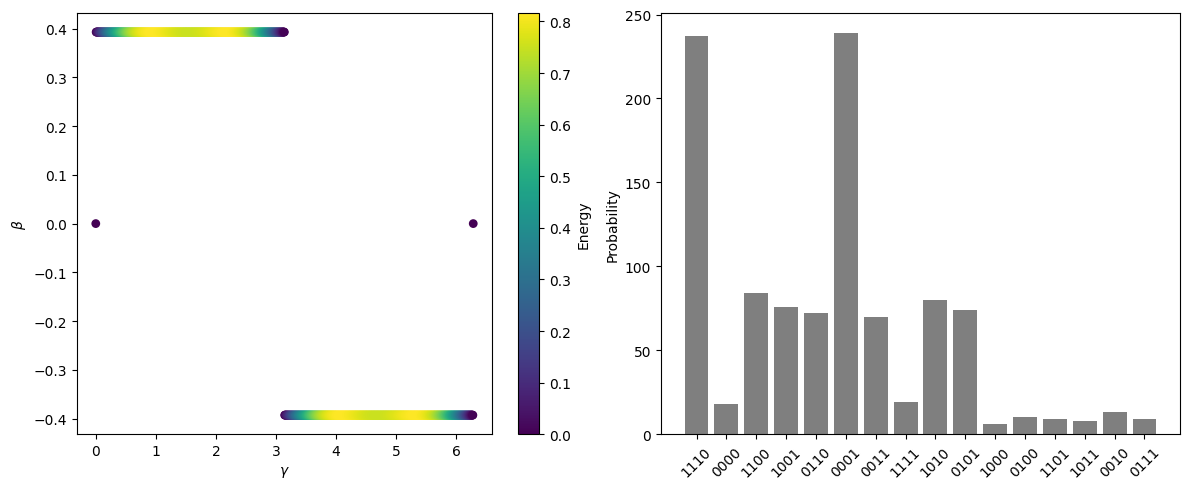

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
trainer.plot(axis=axs[0], fig=fig)
axs[1].bar(list(sampler_result.keys()), list(sampler_result.values()), color="tab:grey")
axs[1].set_ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()

Finally, we convert the energy to the average cut value. With depth-one QAOA we get a value close to 2.30. This is consitent with the fact that the maximum cut has a value of 3 and that the QAOA state has approximatively half of its probability mass on the maximum cut.

In [45]:
result["energy"] + len(graph.edges()) / 2

2.3164962950340584

We now check how the optimal beta value compares to the results of the efficient depth one scanner which scan both gamma and beta values. In the follwoing plot, we show how the optimal beta resides on the maximal energy region for each gamma value.

In [46]:
trainer_depth_one = DepthOneScanTrainer(EfficientDepthOneEvaluator())
result_depth_one_scanner = trainer_depth_one.train(cost_op, num_points=20)

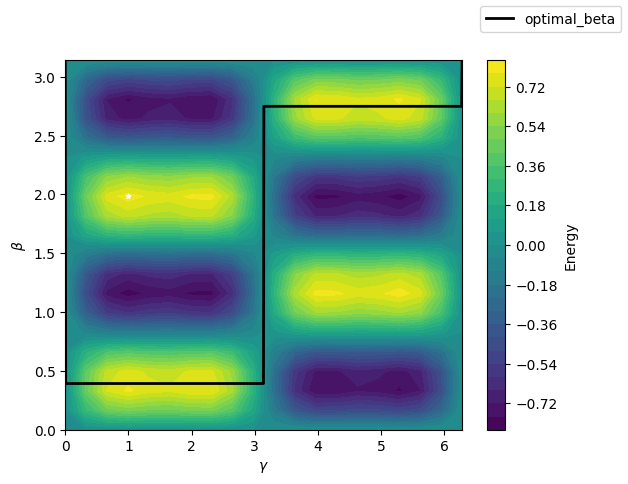

In [57]:
fig, axis = trainer_depth_one.plot()
gamma_vals = trainer._params2
beta_vals = trainer._params1
beta_vals = [x if x > 0 else x+np.pi for x in beta_vals]
line = axis.plot(gamma_vals, beta_vals, color='black', linewidth=2, label='optimal_beta')
fig.legend()